# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

Отправлять дз не нужно, нужно закоммитить в github. Сдается дз лично преподавателю на рубежном контроле (13 марта)

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Cчитываем данные, полученные в результате выполнения домашнего задания из курса введения, в `data frame` библиотеки `pandas`. Достаем координаты и конвертируем в массив `numpy`. Возможно, в собранном вами файле кодировка будет иной.

In [22]:
data_df = pd.read_csv("checkins.csv", sep=",", index_col=0, header=0, encoding='utf-8')
data_df.head()

,address,checkins,city,country,created,icon,latitude,longitude,pid,title,type,updated,lifetime
0,Мячковский б-р 3а,435,1,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,55.657941,37.751574,1,Baila Baila,4,1.487519e+09,2409 days 06:31:27.488101000
1,Дачная 2а,14,123,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,53.202017,50.141377,2,Lust,4,1.483478e+09,2409 days 06:31:27.488101000
2,Лени Голикова 29,8,2,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,59.843376,30.231480,3,Тайфун,4,1.486398e+09,2409 days 06:31:27.488101000
3,Героев Танкограда 63,8,158,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,55.174954,61.451611,4,Hollywood,4,1.470157e+09,2409 days 06:31:27.488101000
4,Мусы Джалиля 14К1,38,99,1,2010-08-02 13:39:01,https://vk.com/images/places/clubs.png,54.860834,83.091932,5,Барабас,4,1.488720e+09,2409 days 06:31:27.488101000


In [23]:
x = data_df[['latitude', 'longitude']].dropna().values
print x

[[ 55.657941  37.751574]
 [ 53.202017  50.141377]
 [ 59.843376  30.23148 ]
 ..., 
 [ 55.76363   37.597046]
 [ 56.002732  37.209755]
 [ 47.225695  39.72997 ]]


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

In [14]:
N = 56 # put your index here

In [15]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [32]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans, k_means
#import imp
#foo = imp.load_source('kMeans', '/usr/local/lib/python2.7/dist-packages/sklearn/cluster/k_means_.py')

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.k = kwargs.get('k', 3)
        self.max_iter = kwargs.get('max_iter', 100)
        self.eps = kwargs.get('eps', 1e-5)
        self.P = lambda indk: mvn(mean=self.mu[indk], cov=self.sigma[indk], allow_singular=True).pdf
        self.ll = []
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        print("Computing for {} clusters...".format(self.k))
        np.random.seed(None)
        
        self.data = x
        N, f = x.shape  # number of objects, number of features
        self.pi = np.ones(self.k) / self.k  # prior probability
        
        # k-means++ initialization
        #kmeans = KMeans(n_clusters=self.k, max_iter=1).fit(self.data)
        #self.mu = kmeans.cluster_centers_
        self.mu = k_means(self.data, n_clusters=self.k, max_iter=1)[0]
        #self.mu = foo._k_init(self.data, n_clusters=self.k)
        
        self.sigma = [np.identity(f) + 0.1 * np.random.rand(f, f) for k in xrange(self.k)]
        self.gamma = np.zeros((N, self.k))  # posterior probability
        
        for ind in xrange(self.max_iter):
            # E-step
            for k in xrange(self.k):
                self.gamma[:, k] = self.pi[k] * np.array(map(self.P(k), x))
            
            self.gamma = (self.gamma.T / np.sum(self.gamma, axis=1)).T
            self.ll.append(np.sum(np.log(np.sum(self.gamma, axis = 1))))
            self.gamma[np.isnan(self.gamma)] = 1
            
            # M-step
            self.Nk = self.gamma.sum(axis=0)
            for k in xrange(self.k):
                self.mu[k] = self.gamma[:, k].dot(x) / self.Nk[k] if self.Nk[k] != 0 else self.mu[k]
                x_mu = np.matrix(x - self.mu[k])
                self.sigma[k] = 1 / self.Nk[k] * np.multiply(x_mu.T, self.gamma[:, k]).dot(x_mu) if self.Nk[k] != 0 else self.sigma[k]
                
            self.pi = self.Nk / N
            if ind < 2:
                continue
            if abs(self.ll[-1] - self.ll[-2]) < self.eps:
                break
            
        #print "Final mu:", self.mu
        #print "Final sigma:", self.sigma
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return [np.argmax([self.P(k)(e) for k in xrange(self.k)]) for e in x]
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

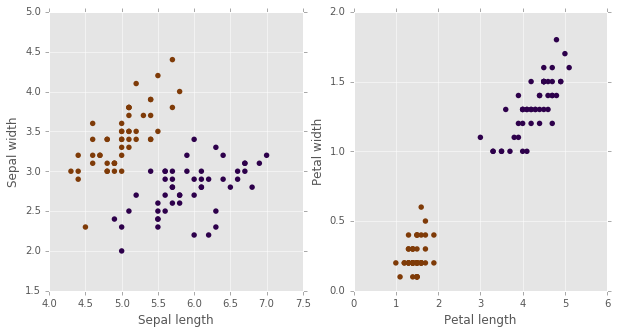

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [33]:
pred_iris = Clustering(k=2, eps=1e-6).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Computing for 2 clusters...
Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [24]:
from scipy.spatial.distance import pdist

def quality(x, y):
    """
    Implement quality criterion of your choice
    Average radius
    """
    clusters = set(y)  # indices of clusters
    counter = np.zeros((len(clusters), 1))
    arr = np.zeros((len(clusters), x.shape[1]))
    for i in xrange(len(x)):
        counter[y[i]] += 1
        arr[y[i]] += x[i]
    for i in xrange(len(clusters)):
        arr[i] /= counter[i]  # now arr holds mean value
    rads = np.zeros(len(clusters))
    for i in xrange(x.shape[0]):
        d = pdist((x[i], arr[y[i]]))[0]
        if d > rads[y[i]]:
            rads[y[i]] = d
    return rads.mean()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [25]:
from time import time
start_time = time()
ks = range(1, 21)
criteria = np.zeros(len(ks))
for i, kk in enumerate(ks):
    cls = Clustering(k=kk)
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)

print "{} seconds spent".format(time() - start_time)

Computing for 1 clusters...


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide


Computing for 2 clusters...
Computing for 3 clusters...
Computing for 4 clusters...
Computing for 5 clusters...
Computing for 6 clusters...
Computing for 7 clusters...
Computing for 8 clusters...
Computing for 9 clusters...
Computing for 10 clusters...
Computing for 11 clusters...
Computing for 12 clusters...
Computing for 13 clusters...
Computing for 14 clusters...
Computing for 15 clusters...
Computing for 16 clusters...
Computing for 17 clusters...
Computing for 18 clusters...
Computing for 19 clusters...
Computing for 20 clusters...
504.828021049 seconds spent


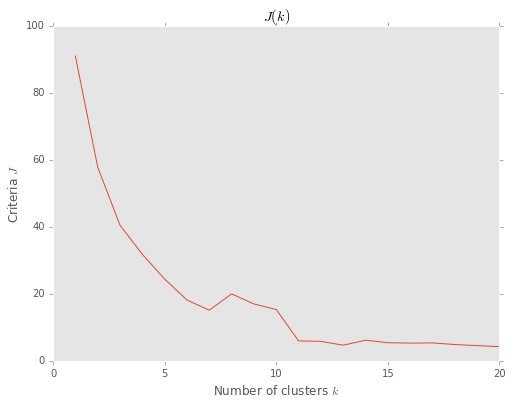

In [26]:
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [30]:
kk = 11
cls = Clustering(k = kk)
y = cls.fit_predict(x)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide


Final mu: [[  59.91187923   30.29325557]
 [  56.14540304   59.95272182]
 [  52.26832603  104.27650022]
 [  55.84802156   37.73217069]
 [  55.01119882   82.93751938]
 [  46.27071142   40.71611364]
 [  54.88849833   47.33608725]
 [  54.89968671   55.3583497 ]
 [  68.81965075   33.0415376 ]
 [  56.02629985   43.6363041 ]
 [  41.48850467  117.43216067]]


Визуализируем кластеризацию на карте

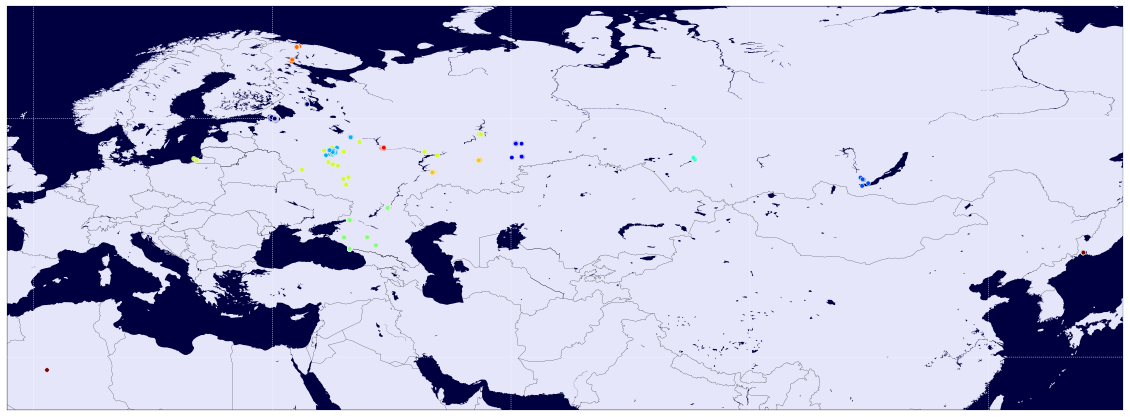

In [45]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', resolution='i',\
               llcrnrlat=min(x[:, 0]) - 5, urcrnrlat=max(x[:, 0]) + 5,\
               llcrnrlon=min(x[:, 1]) - 5, urcrnrlon=max(x[:, 1]) + 5)

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

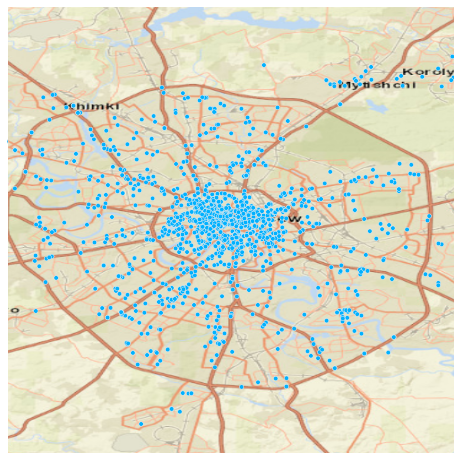

In [61]:
# Moscow
mos_clat, mos_clon = 55.75, 37.62
diam = 0.5

pl.figure(figsize=(14,8))

m = bm.Basemap(projection='cyl', resolution='l',\
               llcrnrlat=mos_clat - diam / 2, urcrnrlat=mos_clat + diam / 2,\
               llcrnrlon=mos_clon - diam / 2, urcrnrlon=mos_clon + diam / 2)
m.arcgisimage(service='World_Street_Map', xpixels=500)
#m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=500)
m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

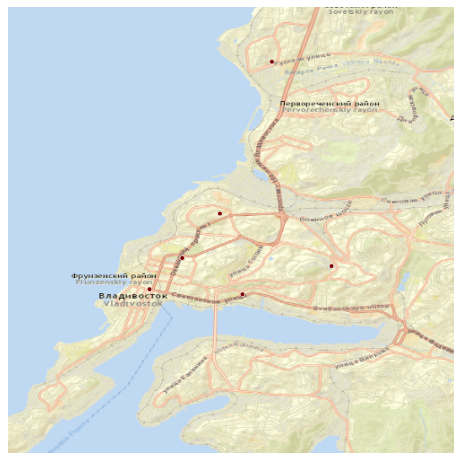

In [68]:
# Vladivostok
vld_clat, vld_clon = 43.13, 131.9
diam = 0.10

pl.figure(figsize=(14,8))

m = bm.Basemap(projection='cyl', resolution='l',\
               llcrnrlat=vld_clat - diam / 2, urcrnrlat=vld_clat + diam / 2,\
               llcrnrlon=vld_clon - diam / 2, urcrnrlon=vld_clon + diam / 2)
m.arcgisimage(service='World_Street_Map', xpixels=500)
#m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=500)
m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

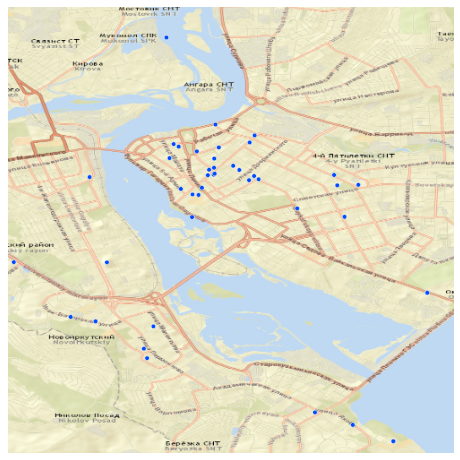

In [72]:
# Irkutsk
irk_clat, irk_clon = 52.27, 104.29
diam = 0.10

pl.figure(figsize=(14,8))

m = bm.Basemap(projection='cyl', resolution='l',\
               llcrnrlat=irk_clat - diam / 2, urcrnrlat=irk_clat + diam / 2,\
               llcrnrlon=irk_clon - diam / 2, urcrnrlon=irk_clon + diam / 2)
m.arcgisimage(service='World_Street_Map', xpixels=500)
#m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=500)
m.scatter(x[:, 1], x[:,0], c=y, zorder=10)
    
pl.show()

Какой вывод можно сделать о качестве кластеризации?

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.